# Information Pursuit: A Wikispeedia Analysis

This notebook developes an in-depth analysis of the `Wikispeedia` dataset. The goal is to identify the characteristics of human navigation paths, and use this knowledge to produce useful insights on how to assess the difficulty of arbitrary pairs of articles, and the downfalls of common human strategies.

This study requires advanced inspection of the Wikispeedia network of pages, and the results collected from multiple thousand games.

This notebook is divided into four main parts:
1. Wikispeedia network analysis
2. Path Efficiency Analysis
3. Navigation Strategies

In [ ]:
%load_ext autoreload
%autoreload 2

### Understanding the data

Before stepping into the analysis, we first describe briefly the data at hand. This also allows us to show a few transformations that have been done to ease data manipulation.

Load and transform some data to make it easy to use

In [ ]:
from src.utils.data_utils import load_graph_data

graph_data = load_graph_data()

loading raw data from tsv files...
formatting articles...
formatting categories...
formatting links...
formatting paths...
formatting distance matrix...
converting distance matrix to dataframe...
building graph...


In [ ]:
from src.utils.general_utils import describe_dict

describe_dict(graph_data)

Keyword                       | Type (shape)          
------------------------------------------------------
shortest-path-distance-matrix   DataFrame (319476, 1) 
paths_finished                  DataFrame (51318, 9)  
articles                        DataFrame (4604, 1)   
paths_unfinished                DataFrame (24875, 9)  
links                           DataFrame (119882, 2) 
categories                      DataFrame (5204, 2)   
graph                           DiGraph (4604, 124486)


### Why analysing human behaviors

In [ ]:
# Show differences between paths and shortest paths

paths_info = graph_data["paths_finished"][["hashedIpAddress", "timestamp", "path_length", "source", "target"]].copy()
paths_info.sort_values(by="timestamp", inplace=True)

# only take first path of every player
paths_info = paths_info.groupby(["source", "target", "hashedIpAddress"], as_index=False).first()

paths_info = paths_info[["source", "target", "path_length"]]
paths_info = paths_info.groupby(["source", "target"]).describe()

paths_info["shortest_distance"] = graph_data["shortest-path-distance-matrix"]["optimal_path_length"]

# remove one special case where shortest_distance is nan
paths_info = paths_info[lambda df: ~df.shortest_distance.isna()]

paths_info

path_length                             \
                                          count       mean       std   min   
source       target                                                          
10th_century 11th_century                   3.0   2.000000  0.000000   2.0   
             Country                        1.0   3.000000       NaN   3.0   
14th_century African_slave_trade            3.0   7.333333  2.081666   5.0   
             Elizabeth_I_of_England         4.0   7.500000  5.744563   4.0   
             Fire                           1.0   4.000000       NaN   4.0   
...                                         ...        ...       ...   ...   
Zirconium    Hebrew_calendar                1.0   5.000000       NaN   5.0   
             Magna_Carta                    1.0   4.000000       NaN   4.0   
             Robinson_Crusoe                1.0  10.000000       NaN  10.0   
             United_Kingdom                 1.0   4.000000       NaN   4.0   
             Ununbium                       1.0   3.000000       NaN   3.0   

                                                            shortest_distance  
                                      25%   50%   75%   max                    
source       target                                                            
10th_century 11th_century             2.0   2.0   2.0   2.0               1.0  
             Country                  3.0   3.0   3.0   3.0               2.0  
14th_century African_slave_trade      6.5   8.0   8.5   9.0               3.0  
             Elizabeth_I_of_England   4.0   5.0   8.5  16.0               2.0  
             Fire                     4.0   4.0   4.0   4.0               3.0  
...                                   ...   ...   ...   ...               ...  
Zirconium    Hebrew_calendar          5.0   5.0   5.0   5.0               3.0  
             Magna_Carta              4.0   4.0   4.0   4.0               3.0  
             Robinson_Crusoe         10.0  10.0  10.0  10.0               4.0  
             United_Kingdom           4.0   4.0   4.0   4.0               2.0  
             Ununbium                 3.0   3.0   3.0   3.0               2.0  

[5585 rows x 9 columns]

<Axes: title={'center': 'Comparison of encountered vs optimal path lengths'}, xlabel='Average path length of players', ylabel='Optimal length'>

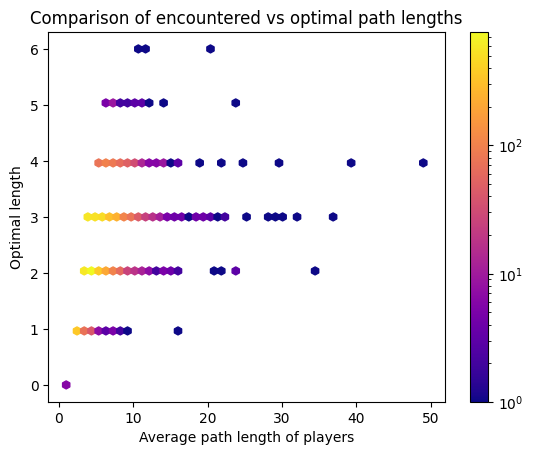

In [ ]:
paths_info.plot.hexbin(
	x=("path_length", "mean"),
	y="shortest_distance",
	title="Comparison of encountered vs optimal path lengths",
	xlabel="Average path length of players",
	ylabel="Optimal length",
	gridsize=50,
	bins="log",
	cmap="plasma",
)

In [ ]:
from scipy import stats

print(stats.pearsonr(paths_info[("path_length", "mean")], paths_info["shortest_distance"]))

PearsonRResult(statistic=np.float64(0.48137486194062207), pvalue=np.float64(5.93e-322))


## Wikispeedia network analysis

It seems quite reasonable to hypothetized that humans navigate the pages of the Wikispeedia website based on relationships existing between the target article concept and the content of the articles found along the way. In order to reason about these semantic relations, humans abstract ideas and form their inner world model, making internalizing concepts efficient and smooth.

In this analysis, we verify if an intuitive top-down approach is indeed the most prevalent strategy of the players.

*Do players have a tendancy to over-utilize hubs of the Wikispeedia networks?*\
*Is this strategy usually paying-off?*

In [ ]:
import networkx as nx
import numpy as np


def compute_hubs(graph):
	hubs = nx.hits(graph, normalized=True)[0]

	distribution = np.array([*hubs.values()])
	mean = np.mean(distribution)
	std = np.std(distribution)

	# check positive outliers in the hub values
	significant_hubs = list(filter(lambda t: t[1] - mean > 8 * std, hubs.items()))
	significant_hubs = sorted(significant_hubs, key=lambda t: t[1], reverse=True)

	return significant_hubs

In [ ]:
compute_hubs(graph_data["graph"])

[('Driving_on_the_left_or_right', 0.0013171632208290821)]

In [ ]:
# TODO: Fred code.

## Path Efficiency Analysis

Lorem ipsum dolor sit amet, consectetur adipiscing elit. Ut fermentum pretium nibh quis accumsan. In at nunc mauris. Integer varius ante non massa pharetra auctor. Interdum et malesuada fames ac ante ipsum primis in faucibus. Sed sit amet commodo nunc. Nulla felis enim, lobortis ut pharetra quis, bibendum sed nunc. Quisque accumsan sapien ac vehicula pretium. Maecenas quis tellus hendrerit, bibendum felis at, iaculis odio. Nullam sed fringilla lorem. Morbi nunc orci, fringilla vel semper dapibus, blandit quis lacus. Pellentesque habitant morbi tristique senectus et netus et malesuada fames ac turpis egestas.


   - Compare actual paths with shortest paths found computationally
   - Develop metrics for path "efficiency" considering both length and completion time
   - Create visualization tools for path comparison and analysis
   - Analyze distribution of successful vs. abandoned paths

In [ ]:
# TODO: Peter code

# p-values and stuff. logits

In [ ]:
# TODO: Gabriel code

# Graphs and stuff
# people tired => people bad

## Navigation Strategies

It seems quite reasonable to hypothetized that humans navigate the pages of the Wikispeedia website based on relationships existing between the target article concept and the content of the articles found along the way. In order to reason about these semantic relations, humans abstract ideas and form their inner world model, making internalizing concepts efficient and smooth.

In this analysis, we verify if an intuitive top-down approach is indeed the most prevalent strategy of the players.

*Do players have a tendancy to over-utilize hubs of the Wikispeedia networks?*\
*Is this strategy usually paying-off?*

### Top-down approach

Represent user paths as a graph

In [ ]:
from src.data.graph import extract_players_graph

finished_paths_graph = extract_players_graph(graph_data, paths_finished=True)
unfinished_paths_graph = extract_players_graph(graph_data, paths_finished=False)

Note that 4 edges are present in 'paths_finished.tsv' but not in 'links.tsv':
{('Bird', 'Wikipedia_Text_of_the_GNU_Free_Documentation_License'), ('Republic_of_Ireland', 'Éire'), ('Finland', 'Åland'), ('Claude_Monet', 'Édouard_Manet')}
Note that 62 edges are present in 'paths_unfinished.tsv' but not in 'links.tsv':
{('Household_income_in_the_United_States', 'Wikipedia_Text_of_the_GNU_Free_Documentation_License'), ('Batman', 'Wikipedia_Text_of_the_GNU_Free_Documentation_License'), ('Cosmic_microwave_background_radiation', 'Wikipedia_Text_of_the_GNU_Free_Documentation_License'), ('Ireland', 'Éire'), ('Film', 'Wikipedia_Text_of_the_GNU_Free_Documentation_License'), ('Blackbird', 'Wikipedia_Text_of_the_GNU_Free_Documentation_License'), ('Tuna', 'Wikipedia_Text_of_the_GNU_Free_Documentation_License'), ('Peak_District', 'Wikipedia_Text_of_the_GNU_Free_Documentation_License'), ('Makuria', 'Wikipedia_Text_of_the_GNU_Free_Documentation_License'), ('Francisco_Goya', 'Édouard_Manet'), ('Color', 'W

In [ ]:
compute_hubs(finished_paths_graph)

[('United_States', 0.03252328407986499),
 ('Europe', 0.019288972404555495),
 ('United_Kingdom', 0.015584267109294218),
 ('England', 0.014512061177973046),
 ('North_America', 0.01376374273367645),
 ('Earth', 0.012658182958466225),
 ('World_War_II', 0.009468624468380454),
 ('English_language', 0.008884412977769693),
 ('Great_Britain', 0.007144918668458417),
 ('France', 0.0071205427603357)]

In [ ]:
compute_hubs(unfinished_paths_graph)

[('United_States', 0.02245843005865249),
 ('United_Kingdom', 0.01118949329937272),
 ('England', 0.010328107713851743),
 ('Europe', 0.009365067575018654),
 ('Animal', 0.008076413290830507),
 ('North_America', 0.008043926762033967),
 ('Mammal', 0.007004155538156377),
 ('World_War_II', 0.0066776362305523895),
 ('English_language', 0.006385391170843087),
 ('Earth', 0.005854865711796787)]

In [ ]:
# TODO: Timothée code.

### Link Position Impact

Lorem ipsum dolor sit amet, consectetur adipiscing elit. Ut fermentum pretium nibh quis accumsan. In at nunc mauris. Integer varius ante non massa pharetra auctor. Interdum et malesuada fames ac ante ipsum primis in faucibus. Sed sit amet commodo nunc. Nulla felis enim, lobortis ut pharetra quis, bibendum sed nunc. Quisque accumsan sapien ac vehicula pretium. Maecenas quis tellus hendrerit, bibendum felis at, iaculis odio. Nullam sed fringilla lorem. Morbi nunc orci, fringilla vel semper dapibus, blandit quis lacus. Pellentesque habitant morbi tristique senectus et netus et malesuada fames ac turpis egestas.

In [ ]:
# TODO: Timothée code

## Conclusion

Lorem ipsum dolor sit amet, consectetur adipiscing elit. Ut fermentum pretium nibh quis accumsan. In at nunc mauris. Integer varius ante non massa pharetra auctor. Interdum et malesuada fames ac ante ipsum primis in faucibus. Sed sit amet commodo nunc. Nulla felis enim, lobortis ut pharetra quis, bibendum sed nunc. Quisque accumsan sapien ac vehicula pretium. Maecenas quis tellus hendrerit, bibendum felis at, iaculis odio. Nullam sed fringilla lorem. Morbi nunc orci, fringilla vel semper dapibus, blandit quis lacus. Pellentesque habitant morbi tristique senectus et netus et malesuada fames ac turpis egestas.